# Goal:
This notebook is used to create a predictive model to see what college basketball player could be be drafted into the nba. The model will look at highschool rankings and college basketball stats to predict if this player could be an NBA player. We use this model to get a percentage that the player could get drafted and use that as a threshold for our second model. 

Note: We have issues with imblearn being installed in-line, so please run `pip install imblearn` in a terminal window and restart the kernel.

In [1]:
! pip install yellowbrick lifelines sportsreference
! pip install -e "git+https://github.com/perrygeo/jenks.git#egg=jenks"
import pandas as pd
import numpy as np
import getpass
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.externals import joblib as jb
from jenks import jenks
from yellowbrick.classifier import ROCAUC
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(14, 10)})

Obtaining jenks from git+https://github.com/perrygeo/jenks.git#egg=jenks
  Updating ./src/jenks clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 80b2557d635ba4a0640157d3616b50dbf39c2221
  Found existing installation: jenks 1.0
    Uninstalling jenks-1.0:
      Successfully uninstalled jenks-1.0
  Running setup.py develop for jenks


/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
mypasswd = getpass.getpass()
conn = psycopg2.connect(database = 'cs20_group4',
                              user = 'jpcp73', #replace with pawprint
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)
cursor = conn.cursor()

········


Here is where we bring in the college data from our database. First we create a temp table where we collect all our college statistics. We also start creating some of the more advanced stats by combining some of the counting statistics together (field goal % = field goals / field goal attemps, ect.). We also ignore college basketball data from before 2001, this is from the amount of missing data we have before this date (For more information on this please visit our earlier notebooks where we go more indepth on the missing data). We join this temp table with our master player table, we bring high school rankings from the master table. We only select players from after 2009 in this step because of the missing data.

In [3]:
data = pd.read_sql_query("""
DROP TABLE IF EXISTS college;

select 
base.*,
most_minutes.assist_percentage,
most_minutes.turnover_percentage,
most_minutes.usage_percentage,
position.position,
team.team_abbreviation,
conference.conference
INTO TEMP TABLE college
from
--Base query where all simple aggregations are performed, usually sum or max. For some percentage fields,
    --the field are here recalculated according to the definitions in the SportsReference package documentation.
    (select 
    sum(assists) as assists,
    sum(blocks) as blocks,
    max(avg_conf_rank) as conference_rank,
    sum(defensive_rebounds) as defensive_rebounds,
    sum(defensive_win_shares) as defensive_win_shares,
    sum(field_goal_attempts) as field_goal_attempts,
    --field_goal_percentage,
    case when sum(field_goal_attempts) > 0 then
    sum(field_goals)/sum(field_goal_attempts)
    else null end as field_goal_percentage,
    sum(field_goals) as field_goals,
    --free_throw_attempt_rate,
    case when sum(field_goal_attempts) > 0 then
    sum(free_throw_attempts)/sum(field_goal_attempts) 
    else null end as free_throw_attempt_rate,
    sum(free_throw_attempts) as free_throw_attempts,
    --free_throw_percentage,
    case when sum(free_throw_attempts) > 0 then
    sum(free_throws)/sum(free_throw_attempts) 
    else null end as free_throw_percentage,
    sum(free_throws) as free_throws,
    sum(games_played) as games_played,
    sum(games_started) as games_started,
    max(height) as height,
    sum(minutes_played) as minutes_played,
    sum(offensive_rebounds) as offensive_rebounds,
    sum(offensive_win_shares) as offensive_win_shares,
    sum(personal_fouls) as personal_fouls,
    player_id,
    sum(points) as points,
    sum(steals) as steals,
    --three_point_attempt_rate,
    case when sum(field_goal_attempts) > 0 then
    sum(three_point_attempts)/sum(field_goal_attempts) 
    else null end as three_point_attempt_rate,
    sum(three_point_attempts) as three_point_attempts,
    --three_point_percentage,
    case when sum(three_point_attempts) > 0 then
    sum(three_pointers)/sum(three_point_attempts) 
    else null end as three_point_percentage,
    sum(three_pointers) as three_pointers,
    sum(total_rebounds) as total_rebounds,
    sum(turnovers) as turnovers,
    sum(two_point_attempts) as two_point_attempts,
    --two_point_percentage,
    case when sum(two_point_attempts) > 0 then
    sum(two_pointers)/sum(two_point_attempts) 
    else null end as two_point_percentage,
    sum(two_pointers) as two_pointers,
    max(weight) as weight,
    sum(win_shares) as win_shares,
    max(player_season_number) as seasons_played
    from 
    ncaa_player_career_stats2
    where
    season >= '2001'
    group by
    player_id) base
--This outer join adds columns for percentages that could not be recaclulated.
    --Instead, this query takes the value from each of these fields during the season in which a player logged the most minutes of playing time.
left outer join
    (select distinct
    sub1.player_id,
    avg(sub2.assist_percentage) as assist_percentage,
    avg(sub2.turnover_percentage) as turnover_percentage,
    avg(sub2.usage_percentage) as usage_percentage,
    avg(sub2.win_shares_per_40_minutes) as win_shares_per_40_minutes,
    avg(sub2.block_percentage) as block_percentage 
            --In tandem, these two queries filter the dataframe to just the seasons where each player played the most minutes.
    from
    (select
    player_id,
    max(minutes_played) as minutes_played
    from 
    ncaa_player_career_stats2
    where
    season >= '2001'
    group by player_id)sub1
    left outer join
    (select
    player_id,
    minutes_played,
    assist_percentage,
    turnover_percentage,
    usage_percentage,
    win_shares_per_40_minutes,
    block_percentage
    from 
    ncaa_player_career_stats2)sub2
    on sub1.player_id = sub2.player_id and sub1.minutes_played = sub2.minutes_played
    group by
    sub1.player_id) most_minutes
    on base.player_id = most_minutes.player_id
--Each of the following outer joins brings in a column that is non-numeric.  The mode is used for some of these columns, like school, so if a player transfered, we treat the school he played the most seasons for as his school.  In the case of a tie, a value is arbatrarily chosen.
left outer join
    (select player_id, mode() within group(order by conference) as conference
    from
    ncaa_player_career_stats2
    group by
    player_id)conference
    on conference.player_id = base.player_id
    left outer join
    (select player_id, mode() within group(order by team_abbreviation) as team_abbreviation
    from
    ncaa_player_career_stats2
    group by
    player_id)team
    on team.player_id = base.player_id
    left outer join
    (select player_id, mode() within group(order by position) as position
    from
    ncaa_player_career_stats2
    group by
    player_id)position
    on position.player_id = base.player_id;
    
SELECT
    p.ncaa_id
    , p.nba_id
    , p.player_name
    , p.height
    , p.weight
    , p.high_school_national_rank
    , p.high_school_recruit_score
    , p.draft_rank
    , p.school_or_team
    , p.highest_level
    , COALESCE(p.nba_draft_year, p.final_college_season, p.high_school_class) - COALESCE(p.high_school_class, p.first_college_season) + 18 as age
    , c.conference
    , c.assists
    , c.blocks
    , c.defensive_rebounds
    , c.field_goal_attempts
    , c.field_goals
    , c.field_goal_percentage
    , c.free_throw_attempt_rate
    , c.free_throw_attempts
    , c.free_throw_percentage
    , c.games_played
    , c.games_started
    , c.minutes_played
    , c.offensive_rebounds
    , c.personal_fouls
    , c.points
    , c.steals
    , c.three_point_attempt_rate
    , c.three_point_attempts
    , c.three_point_percentage
    , c.three_pointers
    , c.total_rebounds
    , c.turnovers
    , c.two_point_attempts
    , c.two_point_percentage
    , c.two_pointers
    , c.seasons_played
    , c.assist_percentage
    , c.turnover_percentage
    , c.usage_percentage
    , c.position
    , c.defensive_win_shares
    , c.offensive_win_shares
    , r.role as nba_career_quality
    , cl.offensive_role as nba_offensive_role
    , cl.defensive_role as nba_defensive_role
    , CASE
        WHEN cr.player_id IS NOT NULL
            THEN 1
            ELSE 0
        END as currently_in_school
FROM college c
JOIN player_master_table p ON c.player_id = p.ncaa_id
LEFT JOIN nba_player_roles r ON p.nba_id = r.player_id
LEFT JOIN nba_player_clusters cl ON p.nba_id = cl.player_id
LEFT JOIN ncaa_current_rosters cr ON p.ncaa_id = cr.player_id
WHERE c.minutes_played IS NOT NULL
    AND p.final_college_season >= 2009
""", con = conn)
print(data.shape)
data.head()

(22234, 48)


,ncaa_id,nba_id,player_name,height,weight,high_school_national_rank,high_school_recruit_score,draft_rank,school_or_team,highest_level,age,conference,assists,blocks,defensive_rebounds,field_goal_attempts,field_goals,field_goal_percentage,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,games_played,games_started,minutes_played,offensive_rebounds,personal_fouls,points,steals,three_point_attempt_rate,three_point_attempts,three_point_percentage,three_pointers,total_rebounds,turnovers,two_point_attempts,two_point_percentage,two_pointers,seasons_played,assist_percentage,turnover_percentage,usage_percentage,position,defensive_win_shares,offensive_win_shares,nba_career_quality,nba_offensive_role,nba_defensive_role,currently_in_school
0,aakim-saintil-1,None,Aakim Saintil,72.0,165.0,NaN,NaN,NaN,LIU-Brooklyn,NCAA,18.0,northeast,146.0,1.0,57.0,304.0,112.0,0.368421,0.546053,166.0,0.807229,31.0,25.0,906.0,12.0,104.0,392.0,46.0,0.427632,130.0,0.261538,34.0,69.0,90.0,174.0,0.448276,78.0,1.0,0.307,0.190,0.245,Guard,0.9,1.2,None,None,None,0
1,aakim-saintill-1,None,Aakim Saintil,72.0,165.0,284.0,0.8333,NaN,South Alabama,NCAA,19.0,sun-belt,57.0,2.0,46.0,167.0,55.0,0.329341,0.526946,88.0,0.738636,31.0,10.0,705.0,16.0,102.0,194.0,32.0,0.419162,70.0,0.271429,19.0,62.0,45.0,97.0,0.371134,36.0,1.0,0.165,0.177,0.183,Guard,0.8,0.2,None,None,None,0
2,aalim-moor-1,None,Aalim Moor,75.0,194.0,535.0,0.8181,NaN,San Jose State,NCAA,22.0,wac,29.0,3.0,22.0,73.0,32.0,0.438356,0.041096,3.0,0.333333,65.0,2.0,359.0,3.0,40.0,75.0,10.0,0.328767,24.0,0.416667,10.0,25.0,21.0,49.0,0.448980,22.0,4.0,0.216,0.259,0.138,Guard,0.1,0.1,None,None,None,0
3,aamahd-walker-1,None,Aamahd Walker,74.0,190.0,NaN,NaN,NaN,UCSB,NCAA,19.0,big-west,2.0,1.0,8.0,21.0,8.0,0.380952,0.428571,9.0,0.555556,17.0,0.0,73.0,4.0,7.0,22.0,5.0,0.238095,5.0,0.200000,1.0,12.0,5.0,16.0,0.437500,7.0,2.0,0.063,0.210,0.207,Guard,0.1,0.0,None,None,None,0
4,aamahne-santos-1,None,Aamahne Santos,70.0,165.0,NaN,NaN,NaN,Jacksonville,NCAA,18.0,atlantic-sun,78.0,2.0,47.0,202.0,73.0,0.361386,0.143564,29.0,0.965517,32.0,31.0,915.0,10.0,43.0,217.0,20.0,0.628713,127.0,0.338583,43.0,57.0,49.0,75.0,0.400000,30.0,1.0,0.139,0.185,0.138,Guard,0.6,0.5,None,None,None,1


In [4]:
data = data.sort_values(by = ['high_school_national_rank']).drop_duplicates(subset = 'ncaa_id').reset_index(drop = True)
print(data.shape)
data.head()

(22046, 48)


,ncaa_id,nba_id,player_name,height,weight,high_school_national_rank,high_school_recruit_score,draft_rank,school_or_team,highest_level,age,conference,assists,blocks,defensive_rebounds,field_goal_attempts,field_goals,field_goal_percentage,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,games_played,games_started,minutes_played,offensive_rebounds,personal_fouls,points,steals,three_point_attempt_rate,three_point_attempts,three_point_percentage,three_pointers,total_rebounds,turnovers,two_point_attempts,two_point_percentage,two_pointers,seasons_played,assist_percentage,turnover_percentage,usage_percentage,position,defensive_win_shares,offensive_win_shares,nba_career_quality,nba_offensive_role,nba_defensive_role,currently_in_school
0,harrison-barnes-1,barneha02,Harrison Barnes,80.0,225.0,1.0,0.9999,3.0,UNC,NBA,20.0,acc,96.0,29.0,265.0,1018.0,438.0,0.430255,0.313360,319.0,0.733542,75.0,73.0,2198.0,149.0,140.0,1226.0,68.0,0.326130,332.0,0.349398,116.0,414.0,146.0,686.0,0.469388,322.0,2.0,0.072,0.108,0.281,Forward,3.7,5.6,Starter,Secondary creator,Secondary defender,0
1,rj-barrett-1,barrerj01,RJ Barrett,79.0,210.0,1.0,1.0000,3.0,Duke,NBA,19.0,acc,164.0,16.0,229.0,702.0,319.0,0.454416,0.319088,224.0,0.665179,38.0,38.0,1341.0,59.0,70.0,860.0,34.0,0.337607,237.0,0.308017,73.0,288.0,123.0,465.0,0.529032,246.0,1.0,0.235,0.132,0.322,Forward,2.7,3.8,Starter,None,None,0
2,andrew-wiggins-1,wiggian01,Andrew Wiggins,80.0,194.0,1.0,1.0000,3.0,Kansas,NBA,19.0,big-12,54.0,34.0,129.0,422.0,189.0,0.447867,0.537915,227.0,0.775330,35.0,35.0,1148.0,76.0,94.0,597.0,41.0,0.298578,126.0,0.341270,43.0,205.0,80.0,296.0,0.493243,146.0,1.0,0.092,0.131,0.263,Guard,1.7,3.2,Starter,Offensive centerpiece,Secondary defender,0
3,josh-jackson-2,jacksjo02,Josh Jackson,80.0,200.0,1.0,0.9999,1.0,Kansas,NBA,19.0,big-12,104.0,37.0,177.0,429.0,220.0,0.512821,0.403263,173.0,0.566474,35.0,35.0,1077.0,81.0,104.0,572.0,59.0,0.209790,90.0,0.377778,34.0,258.0,97.0,339.0,0.548673,186.0,1.0,0.182,0.159,0.272,Guard,2.2,2.7,Starter,Secondary creator,Secondary defender,0
4,derrick-favors-1,favorde01,Derrick Favors,82.0,265.0,1.0,0.9997,3.0,Georgia Tech,NBA,19.0,acc,37.0,74.0,195.0,293.0,179.0,0.610922,0.488055,143.0,0.629371,36.0,35.0,989.0,108.0,94.0,448.0,32.0,0.003413,1.0,0.000000,0.0,303.0,90.0,292.0,0.613014,179.0,1.0,0.079,0.200,0.218,Forward,2.5,2.3,Star,Post threat,Defensive centerpiece,0


The target of the model is if the player made the NBA, so we want our target column to be a binary column. Below we change the target from a String column to a binary column. 

In [5]:
data['made_nba'] = (data.highest_level == 'NBA').astype(int)

We have some data that we need to manually adjust to ensure correctness.

In [6]:
data.loc[data.player_name == 'Cam Reddish', 'draft_rank'] = 16.0
data.loc[data.player_name == 'Byron Mullens', 'draft_rank'] = 9.0
data.loc[data.player_name == 'Jeff Ayres', 'draft_rank'] = 39.0
data.loc[data.player_name == 'Joe Young', 'draft_rank'] = 44.0
data.loc[data.player_name == 'Maurice Harkless', 'draft_rank'] = 14.0
data.loc[(data.player_name == 'Devin Booker') & (data.school_or_team == 'Clemson'), 'made_nba'] = 0

Change the rows with Null values into zeros, or in the cases with ranks, make them outside the higher rank range.

In [7]:
data.loc[data.field_goal_percentage.isnull(), 'field_goal_percentage'] = 0
data.loc[data.free_throw_attempt_rate.isnull(), 'free_throw_attempt_rate'] = 0
data.loc[data.free_throw_percentage.isnull(), 'free_throw_percentage'] = 0
data.loc[data.three_point_attempt_rate.isnull(), 'three_point_attempt_rate'] = 0
data.loc[data.three_point_percentage.isnull(), 'three_point_percentage'] = 0
data.loc[data.two_point_percentage.isnull(), 'two_point_percentage'] = 0
data.loc[data.assist_percentage.isnull(), 'assist_percentage'] = 0
data.loc[data.turnover_percentage.isnull(), 'turnover_percentage'] = 0
data.loc[data.usage_percentage.isnull(), 'usage_percentage'] = 0
data.loc[data.high_school_national_rank.isnull(), 'high_school_national_rank'] = 1001
data.loc[data.high_school_recruit_score.isnull(), 'high_school_recruit_score'] = 0
data.loc[data.draft_rank.isnull(), 'draft_rank'] = 101

Now that we have the data in a dataframe we can start creating a few more important columns. The features we put into the model are important to not over value small sample sizes, so we create columns with the counting stats in a per minute form. This will normalize some of the effect of the small sample sizes. Then we put all our features into a list to call easily later. 

In [8]:
data['height_to_weight'] = data.height / data.weight
data['weight_to_height'] = data.weight / data.height
data['recruit_draft_rank_mean'] = data[['high_school_national_rank', 'draft_rank']].mean(axis = 1)
data['draft_recruit_ratio'] = data.draft_rank.astype(int) / data.high_school_national_rank.astype(int)
data['assist_to_turnover_ratio'] = data.assists / data.turnovers
data['assists_per_minute'] = data.assists / data.minutes_played
data['blocks_per_minute'] = data['blocks'] / data.minutes_played
data['drb_per_minute'] = data.defensive_rebounds / data.minutes_played
data['fga_per_minute'] = data.field_goal_attempts / data.minutes_played
data['fgm_per_minute'] = data.field_goals / data.minutes_played
data['start_rate'] = data.games_started / data.games_played
data['minutes_per_game'] = data.minutes_played / data.games_played
data['orb_per_minute'] = data.offensive_rebounds / data.minutes_played
data['drb_orb_ratio'] = data.defensive_rebounds / data.offensive_rebounds
data['fouls_per_minute'] = data.personal_fouls / data.minutes_played
data['points_per_minute'] = data.points / data.minutes_played
data['steals_per_minute'] = data.steals / data.minutes_played
data['stocks'] = data.steals + data['blocks']
data['stocks_per_minute'] = data.stocks / data.minutes_played
data['three_attempts_per_minute'] = data.three_point_attempts / data.minutes_played
data['threes_made_per_minute'] = data.three_pointers / data.minutes_played
data['three_to_two_attempt_ratio'] = data.three_point_attempts / data.two_point_attempts
data['three_to_two_make_ratio'] = data.three_pointers / data.two_pointers
data['points_rebounds_ratio'] = data.points / data.total_rebounds
data['points_assists_ratio'] = data.points / data.assists
data['assists_rebounds_ratio'] = data.assists / data.total_rebounds
data['points_rebounds_assists'] = data[['points', 'total_rebounds', 'assists']].sum(axis = 1)
data['points_rebounds_assists_per_minute'] = data.points_rebounds_assists / data.minutes_played
data['win_share_diff_off'] = data.offensive_win_shares - data.defensive_win_shares
data['win_share_diff_def'] = data.defensive_win_shares - data.offensive_win_shares
data['off_ws_per_minute'] = data.offensive_win_shares / data.minutes_played
data['def_ws_per_minute'] = data.defensive_win_shares / data.minutes_played
data['total_win_shares'] = data.offensive_win_shares + data.defensive_win_shares
data['win_shares_per_minute'] = data.total_win_shares / data.minutes_played

In [9]:
features = data.select_dtypes(['int', 'float']).columns.to_list()
features.remove('made_nba')
features.remove('currently_in_school')
features

['height',
 'weight',
 'high_school_national_rank',
 'high_school_recruit_score',
 'draft_rank',
 'age',
 'assists',
 'blocks',
 'defensive_rebounds',
 'field_goal_attempts',
 'field_goals',
 'field_goal_percentage',
 'free_throw_attempt_rate',
 'free_throw_attempts',
 'free_throw_percentage',
 'games_played',
 'games_started',
 'minutes_played',
 'offensive_rebounds',
 'personal_fouls',
 'points',
 'steals',
 'three_point_attempt_rate',
 'three_point_attempts',
 'three_point_percentage',
 'three_pointers',
 'total_rebounds',
 'turnovers',
 'two_point_attempts',
 'two_point_percentage',
 'two_pointers',
 'seasons_played',
 'assist_percentage',
 'turnover_percentage',
 'usage_percentage',
 'defensive_win_shares',
 'offensive_win_shares',
 'height_to_weight',
 'weight_to_height',
 'recruit_draft_rank_mean',
 'draft_recruit_ratio',
 'assist_to_turnover_ratio',
 'assists_per_minute',
 'blocks_per_minute',
 'drb_per_minute',
 'fga_per_minute',
 'fgm_per_minute',
 'start_rate',
 'minutes_per

In [10]:
null_features = [x for x in data[features].columns.to_list() if data[x].isnull().sum() > 0]

In [11]:
for nf in null_features:
    data[nf].fillna(0, inplace = True)

In [12]:
inf_features = [x for x in data[features].columns.to_list() if (data[x] == np.inf).sum() > 0]

In [13]:
for i in inf_features:
    data.loc[data[i] == np.inf, i] = 1

The next step is to start binning our data. The goal for binning was to have some reason behind the size of our bins. This was accomplished by creating the functions below. The python package jenks bins the data in different sizes and then we found the variance fit for each of the sizes of bins and selected the bin that had a variance fit of 0.9. This was to not over fit our binning. We ran these functions across all of our features to select the correct bin size for all of them. 

After the binning was completed we created dummy columns for the bins to get every column to be a binary column. 

In [14]:
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenks(array, classes)

    # do the actual classification
    classified = np.searchsorted(classes, array, side = 'right')

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

In [15]:
def bin_selector(data, threshold = 0.9):
    bins = 1
    gvf = 0
    while gvf < threshold:
        gvf = goodness_of_variance_fit(data, bins + 1)
        bins += 1
    return bins - 1

In [16]:
def bin_assigner(data):
    bins = np.searchsorted(jenks(data, bin_selector(data)), data, side = 'right')
    return bins

In [17]:
for f in features:
    print(f)
    if f == 'draft_rank':
        data['{}_bin'.format(f)] = None
        data.loc[data[f] <= 100, '{}_bin'.format(f)] = bin_assigner(np.array(data.loc[data[f] <= 100][f]))
        data.loc[data[f] > 100, '{}_bin'.format(f)] = data['{}_bin'.format(f)].max() + 1
    else:
        data['{}_bin'.format(f)] = bin_assigner(data[f])

height
weight
high_school_national_rank
high_school_recruit_score


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


draft_rank
age
assists
blocks
defensive_rebounds
field_goal_attempts
field_goals
field_goal_percentage
free_throw_attempt_rate
free_throw_attempts
free_throw_percentage
games_played
games_started
minutes_played
offensive_rebounds
personal_fouls
points
steals
three_point_attempt_rate
three_point_attempts
three_point_percentage
three_pointers
total_rebounds
turnovers
two_point_attempts
two_point_percentage
two_pointers
seasons_played
assist_percentage
turnover_percentage
usage_percentage
defensive_win_shares
offensive_win_shares
height_to_weight
weight_to_height
recruit_draft_rank_mean
draft_recruit_ratio
assist_to_turnover_ratio
assists_per_minute
blocks_per_minute
drb_per_minute
fga_per_minute
fgm_per_minute
start_rate
minutes_per_game
orb_per_minute
drb_orb_ratio
fouls_per_minute
points_per_minute
steals_per_minute
stocks
stocks_per_minute
three_attempts_per_minute
threes_made_per_minute
three_to_two_attempt_ratio
three_to_two_make_ratio
points_rebounds_ratio
points_assists_ratio
assi

In [18]:
binned_cols = [x for x in data.columns.to_list() if '_bin' in x]

In [19]:
df = pd.get_dummies(data, columns = binned_cols)
df['made_nba'] = data.made_nba

In [20]:
new_features = [x for x in df.columns.to_list() if '_bin' in x] + features

In [21]:
df = df[['ncaa_id', 'nba_id', 'player_name', 'currently_in_school'] + new_features + ['made_nba']]

In [22]:
df.to_csv('../Data/binned_data.csv', index = False)

With having multiple models running over the same data sets we wanted to make sure when we train and test our data that both models are seeing the same training and testing data. This was in order to prevent the testing data of one model to be in the training data of the other. It will ensure clean uncompromised testing results. 

This was accomplished by sampling at the same point and using the same random state for each time we load in the data. 

In [23]:
df = pd.read_csv('../Data/binned_data.csv')
train = df.sample(frac = 0.75, random_state = 1)

test = df.drop(train.index)
train.to_csv('../Data/train_data.csv', index = False)
test.to_csv('../Data/test_data.csv', index = False)

df = train
x = np.array(df[new_features])
y = np.array(df.made_nba)

The next step is to get the model up and running. We want the model to run with the best parameters, so we have to set up a gridsearch to find those. We have a lot of features in our data set, so with that we use a select k best diminsion reducing function in our gridsearch to find the optimal amount of features used in our model. Next, we are using a LogisticRegression model as our estimator. This was after experimenting various models such as RandomForest and SVC but settled on a Logistic Regression model which balanced computational efficiency and model accuracy. We then looked at several different parameters to see which will give us the best results for our Logistic Regression. 

We put all of that into our grid search, and we run it with 5 cross validations and our scoring based on the roc auc score. We wanted to look at roc auc score because the ratio of true positives and false positivies is an important measure for when predicting if players will make the NBA. We want to be sure our model is correctly predicting NBA players and not just saying everyone is not an NBA player. 

In [24]:
pipe = Pipeline([
    ('reduce_dim', SelectKBest()),
    ('estimator', LogisticRegression())
])

In [25]:
param_grid = [
    {
        'reduce_dim__score_func': [f_classif, mutual_info_classif],
        'reduce_dim__k' : [3, 5, 10, 25, 50, 75, 100, 150, 200, 'all'],
        'estimator__penalty' : ['l1', 'l2'],
        'estimator__C' : [0.01, 0.1, 1, 10, 100],
        'estimator__class_weight' : ['balanced', None],
        'estimator__fit_intercept' : [True, False],
        'estimator__max_iter' : [50, 100, 250, 500, 1000, 2500],
        'estimator__multi_class' : ['auto', 'ovr']
    }
]

In [26]:
grid = GridSearchCV(pipe, cv = 5, param_grid = param_grid, scoring = 'roc_auc', verbose = 2)

In [27]:
#grid.fit(x, y)

In [28]:
x = np.array(df.drop(['made_nba', 'ncaa_id', 'nba_id', 'player_name'], axis = 1))
y = np.array(df.made_nba)

From our grid search we get the parameters useed in our models below.

In [29]:
kb = SelectKBest(f_classif, k = 10)
kb.fit(x, y)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 47  72 115 157 162 274 286 308 309 325] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k=10, score_func=<function f_classif at 0x7fe063758c80>)

In [30]:
final_features = df.columns[[kb.get_support(True)]].to_list()
final_features

/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


['high_school_recruit_score_bin_2',
 'high_school_recruit_score_bin_4',
 'high_school_recruit_score_bin_5',
 'draft_rank_bin_2',
 'win_shares_per_minute_bin_5',
 'win_shares_per_minute_bin_11',
 'weight',
 'turnover_percentage',
 'offensive_win_shares',
 'win_share_diff_def']

In [31]:
kb_x = kb.fit_transform(x, y)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 47  72 115 157 162 274 286 308 309 325] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Here we load our LogisticRegression with the optimal hyper parameters. We tuned C which is the inverse of regularization strength to the value of 10 which is 10x larger than the default value. Thus, we are decreasing regularization in order to maximize the prediction accuracy of our limited NBA data since our non-nba players population far outweighs our nba player population.  

In [32]:
reg = LogisticRegression(C = 10, max_iter = 2500)
x_train, x_test, y_train, y_test = train_test_split(kb_x, y, random_state = 1)

To produce our final training set of data we use a package call SMOTE. This used to over sample our training data. The amount of data we have from college players who do not make the NBA drowns out the data from the players that do make the NBA. The oversampling will create fake data to boost the amount of NBA player data we do have to make the training data more balanced. This will help the model we create to not only predict that a player would not make the NBA. 

In [33]:
sm = SMOTE()
x_rs, y_rs = sm.fit_resample(x_train, y_train)

In [34]:
reg.fit(x_rs, y_rs)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
y_pred = [x[1] for x in reg.predict_proba(x_test)]

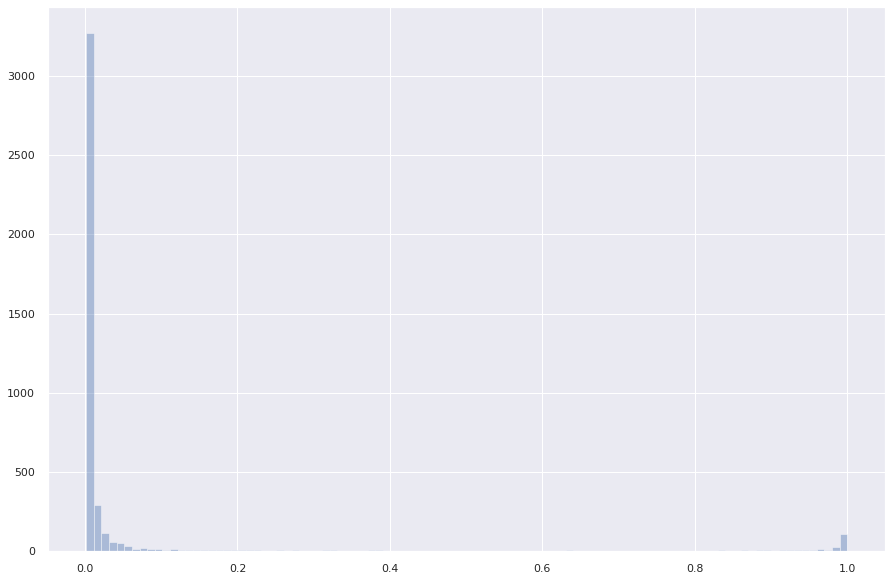

In [36]:
sns.set(rc = {'figure.figsize':(15, 10)})
sns.distplot(y_pred,
            bins = 100,
            kde = False);

In [37]:
df['nba_pred'] = [x[1] for x in reg.predict_proba(kb_x)]

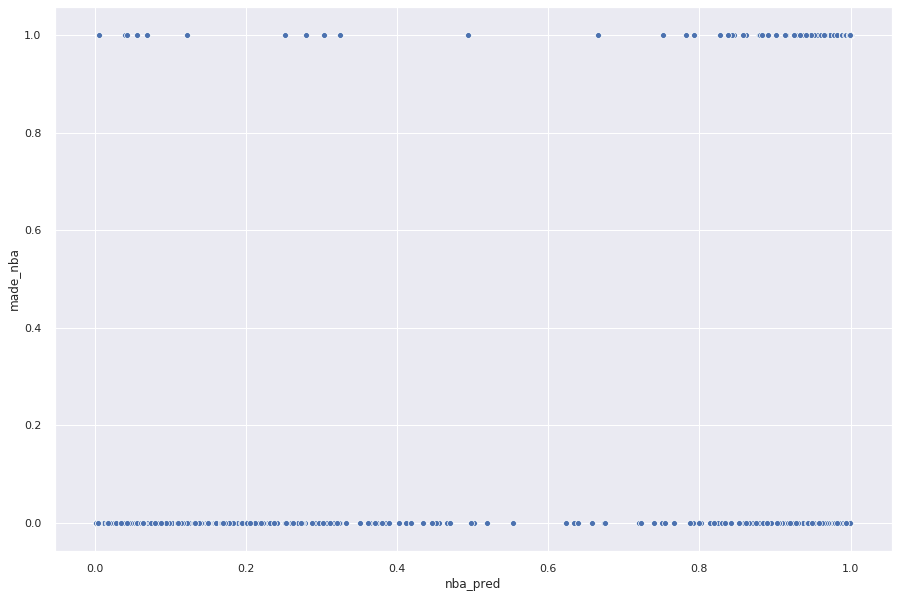

In [38]:
sns.scatterplot(df.nba_pred,
               df.made_nba);

Finally we pickel our model to be used in later steps.

In [39]:
jb.dump(kb, '../Models/nba_model_kbest.pkl')
jb.dump(reg, '../Models/nba_model.pkl')

['nba_model.pkl']